<a href="https://colab.research.google.com/github/srikarraju/GridWorld/blob/main/A2C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
import torch
import gym
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import pandas as pd
from collections import deque

# hyperparameters
hidden_size = 256
learning_rate = 3e-4

# Constants
GAMMA = 0.99
num_steps = 300
max_episodes = 3000

In [ ]:
class ActorCritic(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, learning_rate=3e-4):
        super(ActorCritic, self).__init__()

        self.num_actions = num_actions
        self.critic_linear1 = nn.Linear(num_inputs, hidden_size)
        self.critic_linear2 = nn.Linear(hidden_size, 1)

        self.actor_linear1 = nn.Linear(num_inputs, hidden_size)
        self.actor_linear2 = nn.Linear(hidden_size, num_actions)

    def forward(self, state):
        state = Variable(torch.from_numpy(state).float().unsqueeze(0))
        value = F.relu(self.critic_linear1(state))
        value = self.critic_linear2(value)

        policy_dist = F.relu(self.actor_linear1(state))
        policy_dist = F.softmax(self.actor_linear2(policy_dist), dim=1)

        return value, policy_dist

In [ ]:
def a2c(env):
    num_inputs = env.observation_space.shape[0]
    num_outputs = env.action_space.n

    actor_critic = ActorCritic(num_inputs, num_outputs, hidden_size)
    ac_optimizer = optim.Adam(actor_critic.parameters(), lr=learning_rate)

    all_lengths = []
    average_lengths = []
    all_rewards = []
    entropy_term = 0
    returns = deque(maxlen=100)
    a2c_returns = []
    for episode in range(max_episodes):
        log_probs = []
        values = []
        rewards = []

        state = env.reset()
        for steps in range(num_steps):
            value, policy_dist = actor_critic.forward(state)
            value = value.detach().numpy()[0,0]
            dist = policy_dist.detach().numpy()

            action = np.random.choice(num_outputs, p=np.squeeze(dist))
            log_prob = torch.log(policy_dist.squeeze(0)[action])
            entropy = -np.sum(np.mean(dist) * np.log(dist))
            new_state, reward, done, _ = env.step(action)

            rewards.append(reward)
            values.append(value)
            log_probs.append(log_prob)
            entropy_term += entropy
            state = new_state

            if done or steps == num_steps-1:
                Qval, _ = actor_critic.forward(new_state)
                Qval = Qval.detach().numpy()[0,0]
                all_rewards.append(np.sum(rewards))
                all_lengths.append(steps)
                average_lengths.append(np.mean(all_lengths[-10:]))
                if episode % 100 == 0:
                    sys.stdout.write("episode: {}, reward: {}, total length: {}, average length: {} \n".format(episode, np.sum(rewards), steps, average_lengths[-1]))
                returns.append(np.sum(rewards))
                a2c_returns.append(np.mean(returns))
                break

        # compute Q values
        Qvals = np.zeros_like(values)
        for t in reversed(range(len(rewards))):
            Qval = rewards[t] + GAMMA * Qval
            Qvals[t] = Qval

        #update actor critic
        values = torch.FloatTensor(values)
        Qvals = torch.FloatTensor(Qvals)
        log_probs = torch.stack(log_probs)

        advantage = Qvals - values
        actor_loss = (-log_probs * advantage).mean()
        critic_loss = 0.5 * advantage.pow(2).mean()
        ac_loss = actor_loss + critic_loss + 0.001 * entropy_term

        ac_optimizer.zero_grad()
        ac_loss.backward()
        ac_optimizer.step()



    # Plot results
    smoothed_rewards = pd.Series.rolling(pd.Series(all_rewards), 10).mean()
    smoothed_rewards = [elem for elem in smoothed_rewards]
    # plt.plot(all_rewards)
    # plt.plot(smoothed_rewards)
    # plt.plot()
    # plt.xlabel('Episode')
    # plt.ylabel('Reward')
    # plt.show()

    # plt.plot(all_lengths)
    # plt.plot(average_lengths)
    # plt.xlabel('Episode')
    # plt.ylabel('Episode length')
    plt.plot(a2c_returns)
    plt.show()

episode: 0, reward: 12.0, total length: 11, average length: 11.0 
episode: 100, reward: 10.0, total length: 9, average length: 19.5 
episode: 200, reward: 22.0, total length: 21, average length: 24.7 
episode: 300, reward: 33.0, total length: 32, average length: 31.0 
episode: 400, reward: 21.0, total length: 20, average length: 29.7 
episode: 500, reward: 62.0, total length: 61, average length: 52.6 
episode: 600, reward: 123.0, total length: 122, average length: 70.2 
episode: 700, reward: 39.0, total length: 38, average length: 84.6 
episode: 800, reward: 200.0, total length: 199, average length: 119.0 
episode: 900, reward: 156.0, total length: 155, average length: 142.2 
episode: 1000, reward: 135.0, total length: 134, average length: 107.0 
episode: 1100, reward: 81.0, total length: 80, average length: 144.3 
episode: 1200, reward: 200.0, total length: 199, average length: 189.9 
episode: 1300, reward: 189.0, total length: 188, average length: 172.5 
episode: 1400, reward: 174.0,

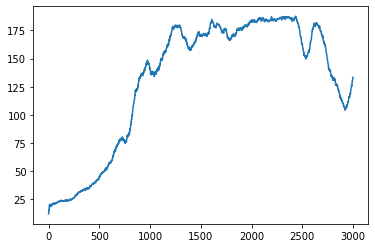

In [ ]:
env = gym.make("CartPole-v0")
a2c(env)